In [97]:
import patchify
import skimage as im
import numpy as np
import os
import matplotlib.pyplot as plt

In [98]:
pip -q install scikit-image

In [ ]:
#location where you have stored the numpy files (the output of Data_creation.ipynb) [User input]

loc_P04 = '/home/saumya/Documents/Schileren_wavelet/Schlieren-Data/Q200-p09/r2sc007-009pq'

#Size of the bins [User input]

bin_size = 8

#The range of values around the largest/dominant frequency amplitude; this is for frequency thresholding or filtering of the data; 
# just to filter out all the low amplitude frequencies; 'theshing 0.9' means all frequencies having magnitude 
# less than 10% of the maximumum is filtered out   [User input]

theshing = .9

#Cut off low fequency, error arising from the FFT at low frequency [User input]

CUTOFF = 10

#Sampling Rate of images [User input]

sampling_rate = 2000 # Adjust this if your data is sampled differently

#Name of the numpy file for data created by the Data_creation code, always in quotes  [User input]

name = "P10"


In [ ]:
name_np = name+'.npy'

loc_p1 = os.path.join(loc_P04, name_np)

data = np.load(loc_p1)

low_cutoff = 1

In [ ]:
data.shape

(3046, 480, 768)

In [ ]:
#To select the time range selection of images, the values can be commented 

#For the selection for the time range in seconds [User input]
#cutting = [0.25, 0.75]

#Uncommenet if want to work with all the images] 
cutting = [0, data.shape[0]]

In [ ]:
# cropped_data = []
# for k in data:
#     cropped_data.append(k[170:385, 70:390])
# cropped_data = np.array(cropped_data)
cropped_data = data[int(cutting[0]*sampling_rate):int(cutting[1]*sampling_rate)]

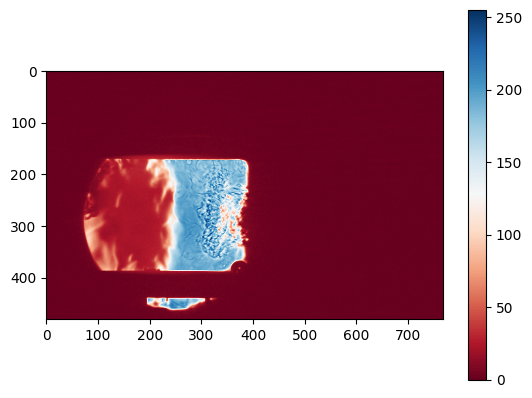

In [ ]:
peg = plt.imshow(cropped_data[200], cmap='RdBu')
plt.colorbar(peg)

In [ ]:
# a sample image from the stack is shown above; the colourbar indicates the pixel intensity (a.u.)
cropped_data.shape

(3046, 480, 768)

In [ ]:
patches = []
for i in range(cropped_data.shape[0]):
    patches.append(patchify.patchify(cropped_data[i], (bin_size, bin_size), bin_size))
patches = np.array(patches)

In [ ]:
mean = np.zeros(patches.shape[:3])
# median = np.zeros(patches.shape[:3])
# mode = np.zeros(patches.shape[:3])
for k in range(cropped_data.shape[0]):
#     # exec(f'mean_{k} = []')
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            mean[k][i][j] = np.mean(patches[k][i][j])
            # median[k][i][j] = np.median(patches[k][i][j])
            # mode[k][i][j] = np.mode(patches[k][i][j])

In [ ]:
mean_all = np.mean(mean)
print(mean_all)
mean_adj = mean - mean_all

20.50273377119412


In [ ]:
from scipy.fft import fft, fftfreq
fft_sig_mean = np.zeros_like(mean).astype(np.complex64)
# fft_sig_median = np.zeros_like(median).astype(np.complex64)
# fft_freq = np.zeros_like(mean).astype(np.complex64)
for i in range(mean.shape[1]):
    for j in range(mean.shape[2]):
            fft_sig_mean[:, i, j] = fft(mean_adj[:, i, j])
            # fft_sig_median[:, i, j] = fft(median[:, i, j])
            # fft_freq[:, i, j] = fftfreq(mean[:, i, j])

In [ ]:
n = fft_sig_mean.shape[0] - low_cutoff # Number of data points
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
frequencies_no_cutoff = np.fft.fftfreq(n+low_cutoff, d= 1/sampling_rate)

In [ ]:
fft_ravel = np.reshape(fft_sig_mean, [np.array(cropped_data).shape[0], fft_sig_mean.shape[1]*fft_sig_mean.shape[2]])

In [ ]:
fft_filter_1000 = fft_ravel[low_cutoff:]

# for i in range(fft_ravel.shape[1]):
#       for k in range(fft_ravel.shape[0]):
#         if (abs(fft_ravel[k][i]<sampling_rate/2)):
#             fft_filter_1000[k][i] = 0
#         else:
#             fft_filter_1000[k][i] = fft_ravel[k][i]

In [ ]:
fft_filter_1000.shape

(3045, 5760)

In [ ]:
fft_ravel.shape

(3046, 5760)

In [ ]:
fft_filter_1000.dtype

dtype('complex64')

In [ ]:
abs(fft_filter_1000.max())

39068.934

In [ ]:
def per_thresh(a, sig):
    new_arr = np.zeros_like(sig)
    top1 = abs(sig.max())
    a1 = 0
    for i,item in enumerate(sig):
        for j,item1 in enumerate(item):
            # print(item)
            if top1*(1-a) < item1:
                a1 = a1+1                                   
                new_arr[i][j] = item1
    return new_arr


In [ ]:
fft_filtered = per_thresh(theshing, fft_filter_1000)

In [ ]:
frequencies.shape

(3045,)

In [ ]:
def freq_pre(sig, freq):
    freq_pre = np.zeros_like(sig, dtype=np.float32)
    for i in range(sig.shape[0]):
        for j in range(sig.shape[1]):
            if abs(sig[i][j]) == 0:
                freq_pre[i][j] = 0
            else:
                freq_pre[i][j] = freq[i]
    return freq_pre

In [ ]:
freq_pre = freq_pre(fft_filtered, frequencies)

In [ ]:
x_data = freq_pre[0:int(freq_pre.shape[0]/2)].astype(np.int32)
y_data = np.absolute(fft_filtered[0:int(freq_pre.shape[0]/2),:]).astype(np.int32)

print(x_data.shape, y_data.shape)

(1522, 5760) (1522, 5760)


In [ ]:
for i in range(x_data.shape[0]):
    for j in range(x_data.shape[1]):
        if x_data[i][j] == 0:
            y_data[i][j] = 0

In [ ]:
def arrange(x, y):
    x_data_sort = np.zeros_like(x)
    y_data_sort = np.zeros_like(y)
    for i in range(x.shape[1]):
        idx = np.argsort(y[:,i])
        x_data_sort[:, i] = x[:, i][idx]
        y_data_sort[:, i] = y[:, i][idx]
    return(x_data_sort, y_data_sort)

In [ ]:
x_data_sort, y_data_sort = arrange(x_data, y_data)

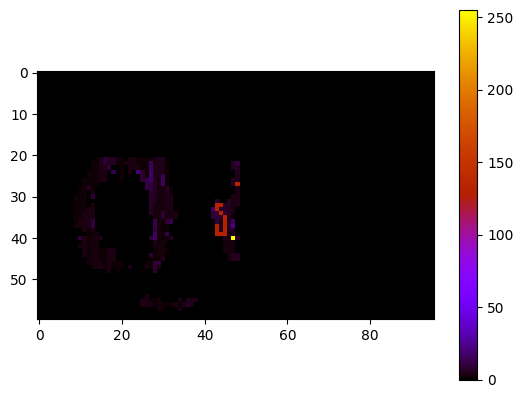

In [ ]:
data = x_data_sort[-1, :].reshape(fft_sig_mean.shape[1:])
img= (data/data.max()*255).astype(np.uint8)
peg = plt.imshow(img, cmap="gnuplot")
plt.colorbar(peg)
plt.savefig("freq-sch_withCB.png") # [file name of the 2D frequency distribution plot with color bar normalized (png 8 bit format normalized (0-255)): User input]

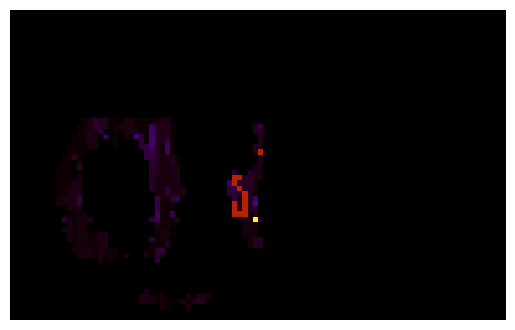

In [ ]:
# The plot above shows the frequency distribution and the colourbar in the plot above represent the first dominant frequency (n = 1) existing in each pixel
data = x_data_sort[-1, :].reshape(fft_sig_mean.shape[1:])
img= (data/data.max()*255).astype(np.uint8)
peg = plt.imshow(img, cmap="gnuplot")
plt.axis('off')
plt.savefig("freq-sch.png", bbox_inches='tight')  # [file name of the 2D frequency distribution plot (png 8 bit format normalized (0-255)): User input]

In [ ]:
# The same 2D frequency distribution plot is repeated without the axes. this image is saved

In [ ]:
def cutoff1(arr1, arr2, max):
    arr3 = arr2
    for i in range(len(arr1)):
        if arr1[i]<max:
            arr3[i] = 0
    return arr3

In [ ]:
max(cutoff1(x_data_sort[-1, :], y_data_sort[-1, :], CUTOFF).astype(np.int16))

13365

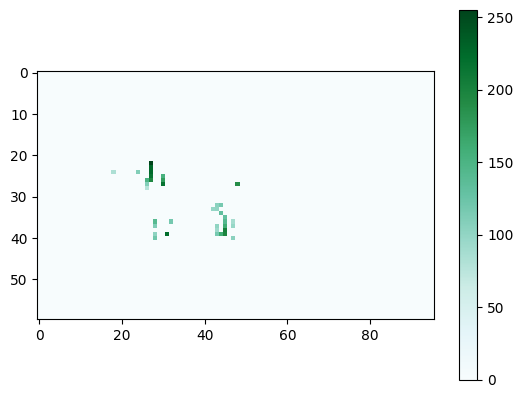

In [ ]:
# peg = plt.imshow(cutoff1(x_data_sort[-1, :], y_data_sort[-1, :], CUTOFF).reshape(fft_sig_mean.shape[1:]), cmap="BuGn")
data = cutoff1(x_data_sort[-1, :], y_data_sort[-1, :], CUTOFF).reshape(fft_sig_mean.shape[1:])
img= (data/data.max()*255).astype(np.uint8)
peg = plt.imshow(img, cmap="BuGn")
plt.colorbar(peg)
plt.savefig("ampl-sch_withCB.png") # file name of the 2D amplitude distribution plot with color bar of the 1st dominant frequency (png format 8 bit normalized (0-255)). [User Input]

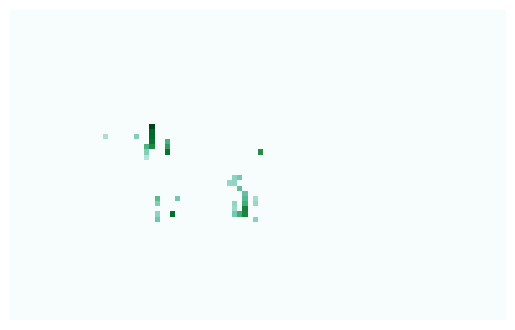

In [ ]:
# The plot above shows the amplitude distribution and the colourbar in the plot above represent the amplitude corresponding to the dominant frequency (n = 1) existing in each pixel

data = cutoff1(x_data_sort[-1, :], y_data_sort[-1, :], CUTOFF).reshape(fft_sig_mean.shape[1:])
img= (data/data.max()*255).astype(np.uint8)
plt.imshow(img, cmap="BuGn")
plt.axis('off')
plt.savefig("ampl-sch.png", bbox_inches='tight') # file name of the 2D amplitude distribution plot of the 1st dominant frequency (png format 8 bit normalized (0-255)). [User Input]

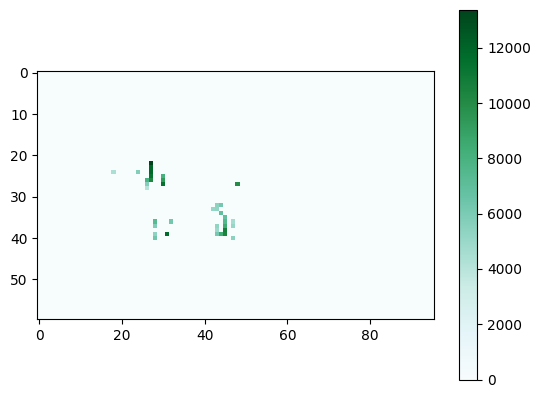

In [ ]:
# the same plot is repeated without the scales. This image is saved.
peg = plt.imshow(y_data_sort[-1, :].reshape(fft_sig_mean.shape[1:]), cmap="BuGn")
plt.colorbar(peg)

In [ ]:
# The plot above shows the amplitude of the first dominant frequency (which was shown before) in each pixel. 

## Here we have to select the pixel for waveletfromation
#### follwing R - C way, select the row number then followed by the column number 

for example the pixel is at (65, 13)
##### give variable pix_loc = [65, 13]

In [ ]:
# Pixel location at which the wavelet of the intensity time series (scalogram) is created [User Input]

pix_loc = [49, 9]  # [row,column]

In [ ]:
sig = np.array(mean_adj[:, pix_loc[0], pix_loc[1]])

In [ ]:
# range(int(cutting[0]*100),int(cutting[1]*100))

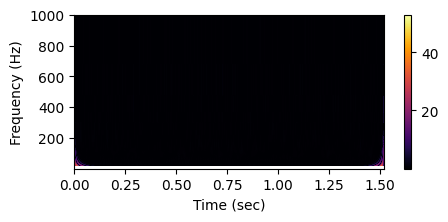

In [ ]:
import pywt 



fs = sampling_rate
sampling_period = 1/fs
t = np.linspace(0, mean_adj.shape[0], mean_adj.shape[0])
t = t/fs
t = t + cutting[0]

wavelet = 'morl'
scale = np.arange(1, 200)


f = pywt.scale2frequency(wavelet, scale)/sampling_period 

coef, freqs = pywt.cwt(sig, scale, wavelet=wavelet,
                       sampling_period=sampling_period)



# Show w.r.t. time and frequency
plt.figure(figsize=(5, 2))
neg = plt.pcolor(t, freqs, abs(coef), cmap='inferno')
plt.colorbar(neg)
# Set yscale, ylim and labels
# plt.yscale('log')
plt.ylim([1, 1000])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
# plt.xticks(np.arange(0.25, 0.76, 0.25))
# plt.savefig('egg_german.png', dpi=150)
plt.savefig("scalo-sch-49-9.png", bbox_inches='tight') # file name of the scalogram. [User Input]

In [ ]:
# The scalogram above shows the frequencies that are existent in the pixel selected for the duration of sampling. 

#### To see the nth dominant frequency just set the value of dis_nth as the 

for example if you want to 3rd dominant freq
dis_nth = 3

In [ ]:
# If you are interested in seeing the next dominant frequencies (n) give the value below [User input] 

dis_nth  = 3

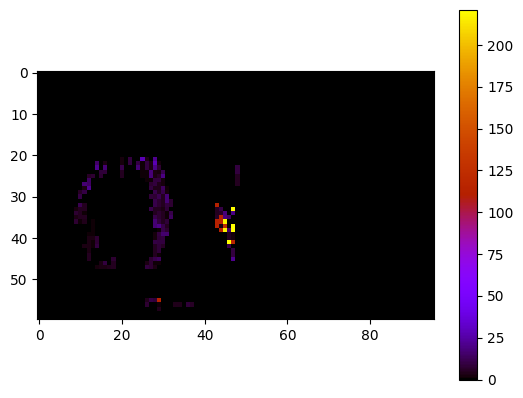

In [ ]:
peg = plt.imshow(x_data_sort[-dis_nth, :].reshape(fft_sig_mean.shape[1:]), cmap="gnuplot")
plt.colorbar(peg)
# plt.imsave(peg)

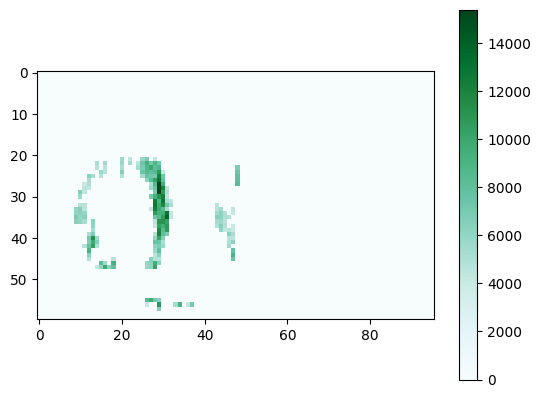

In [ ]:
peg = plt.imshow(y_data_sort[-dis_nth, :].reshape(fft_sig_mean.shape[1:]), cmap="BuGn")
plt.colorbar(peg)

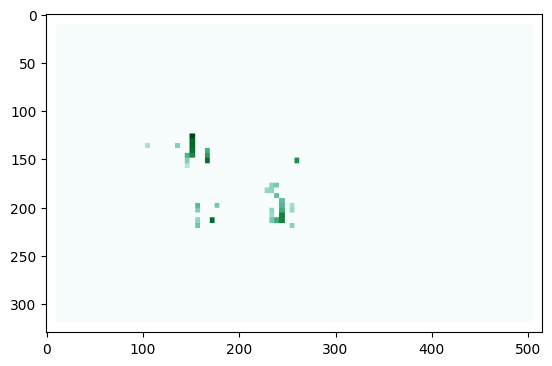

In [ ]:
plt.imshow(a)

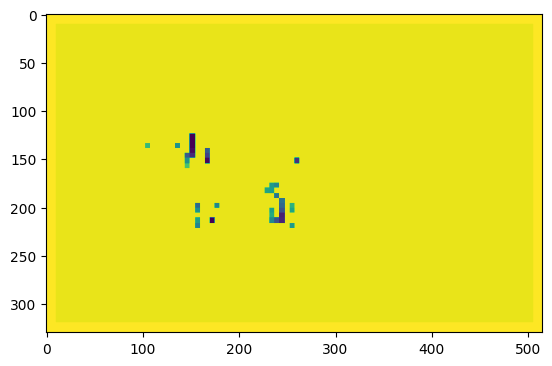

In [ ]:
plt.imshow(a1[:,:,0])